In [3]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# Define the neural network model with sigmoid activation
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden_layer1 = nn.Linear(2, 64)
        self.hidden_layer2 = nn.Linear(64,64)
        self.output_layer = nn.Linear(64, 1)
        self.activation = torch.sigmoid

    def forward(self, x):
        x = self.activation(self.hidden_layer1(x))
        x = self.activation(self.hidden_layer2(x))
        return self.output_layer(x)

In [5]:
# Training the model
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.01)
n_epochs = 5000

In [6]:
# Define the Laplace equation: -Δu = 0
def pde_loss(model, points):
    points.requires_grad_(True)
    u = model(points)
    grads = torch.autograd.grad(
        u, points, grad_outputs=torch.ones_like(u), create_graph=True
    )[0]
    u_x, u_y = grads[:, 0:1], grads[:, 1:2]
    u_xx = torch.autograd.grad(u_x, points, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, 0:1]
    u_yy = torch.autograd.grad(u_y, points, grad_outputs=torch.ones_like(u_y), create_graph=True)[0][:, 1:2]
    return ((u_xx + u_yy) ** 2).mean()

In [7]:
# Define boundary loss
def boundary_loss(model, boundary_points, boundary_values):
    u_pred = model(boundary_points)
    return ((u_pred - boundary_values) ** 2).mean()

# Define U-shape boundary as a polyline
u_shape_polyline = np.array([
    [0.0, 0.0], [1.0, 0.0], [1.0, 1.0], [0.75, 1.0],
    [0.75, 0.25], [0.25, 0.25], [0.25, 1.0], [0.0, 1.0], [0.0, 0.0]
])

In [8]:
from shapely.geometry import Polygon, Point
# Sample boundary points along the U-shape polyline
# Sample boundary points with updated conditions
def sample_boundary_points(n_points):
    boundary_points = []
    boundary_values = []

    for i in range(len(u_shape_polyline) - 1):
        p1 = u_shape_polyline[i]
        p2 = u_shape_polyline[i + 1]
        for t in np.linspace(0, 1, n_points // (len(u_shape_polyline) - 1)):
            point = (1 - t) * p1 + t * p2
            boundary_points.append(point)

            # Set boundary values based on position
            if np.isclose(point[0], 0.0):  # Left boundary
                boundary_values.append(100.0)
            elif np.isclose(point[1], 0.0):  # Bottom boundary
                boundary_values.append(50.0)
            else:
                boundary_values.append(0.0)

    return torch.tensor(boundary_points, dtype=torch.float32), torch.tensor(boundary_values, dtype=torch.float32).unsqueeze(1)

# Sample collocation points inside the U-shaped domain
def sample_collocation_points(n_points):
    polygon = Polygon(u_shape_polyline)
    points = []
    while len(points) < n_points:
        x, y = np.random.uniform(0, 1, size=2)
        if polygon.contains(Point(x, y)):
            points.append([x, y])
    return torch.tensor(points, dtype=torch.float32)

In [9]:
n_collocation = 1000
n_boundary = 200

# Generate collocation and boundary points
collocation_points = sample_collocation_points(n_collocation)
boundary_points, boundary_values = sample_boundary_points(n_boundary)


/var/folders/nh/j5_l42md169dv9d9hh82bvbr0000gn/T/ipykernel_12149/2100680605.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  return torch.tensor(boundary_points, dtype=torch.float32), torch.tensor(boundary_values, dtype=torch.float32).unsqueeze(1)


In [10]:
for epoch in tqdm(range(n_epochs)):
    optimizer.zero_grad()
    loss_pde = pde_loss(model, collocation_points)
    loss_bc = boundary_loss(model, boundary_points, boundary_values)
    loss = loss_pde + loss_bc
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

  0%|          | 17/5000 [00:00<00:52, 95.69it/s]

Epoch 0, Loss: 1648.721435546875


 11%|█         | 530/5000 [00:02<00:21, 211.00it/s]

Epoch 500, Loss: 713.6362915039062


 21%|██        | 1035/5000 [00:05<00:18, 213.52it/s]

Epoch 1000, Loss: 627.6565551757812


 30%|███       | 1519/5000 [00:08<00:19, 181.99it/s]

Epoch 1500, Loss: 622.4893188476562


 41%|████      | 2026/5000 [00:10<00:13, 222.75it/s]

Epoch 2000, Loss: 539.9724731445312


 50%|█████     | 2521/5000 [00:13<00:16, 146.41it/s]

Epoch 2500, Loss: 509.1341857910156


 61%|██████    | 3027/5000 [00:15<00:09, 204.19it/s]

Epoch 3000, Loss: 478.23974609375


 70%|███████   | 3519/5000 [00:18<00:08, 166.49it/s]

Epoch 3500, Loss: 425.9287109375


 80%|████████  | 4013/5000 [00:22<00:07, 138.78it/s]

Epoch 4000, Loss: 423.53533935546875


 91%|█████████ | 4529/5000 [00:26<00:02, 189.91it/s]

Epoch 4500, Loss: 427.2189636230469


100%|██████████| 5000/5000 [00:28<00:00, 175.64it/s]


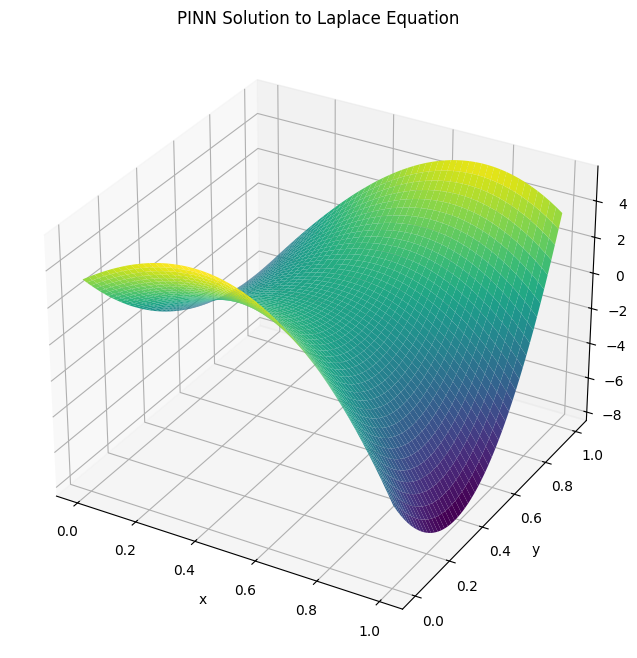

In [9]:
from mpl_toolkits.mplot3d import Axes3D

# Generate grid for plotting
x = np.linspace(0, 1, 50)
y = np.linspace(0, 1, 50)
X, Y = np.meshgrid(x, y)
XY = torch.tensor(np.column_stack([X.ravel(), Y.ravel()]), dtype=torch.float32)

# Predict solution on the grid
u_pred = model(XY).detach().numpy().reshape(X.shape)

# Plot in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, u_pred, cmap="viridis", edgecolor="none")
ax.set_title("PINN Solution to Laplace Equation")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("u(x, y)")
plt.show()

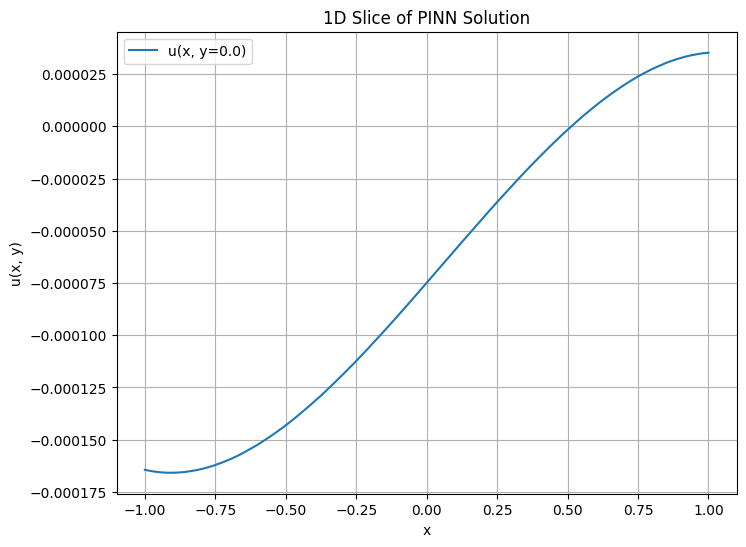

In [14]:
# Generate 1D data along a fixed y value (e.g., y = 0.5)
# Extract a 1D slice for y = 0
fixed_y = 0.0
x_values = np.linspace(-1, 1, 100)  # Cover the full width of the circle
points_slice = torch.tensor(np.column_stack([x_values, np.full_like(x_values, fixed_y)]), dtype=torch.float32)

# Predict the solution for the slice
# with torch.no_grad():
u_1d_pred = model(points_slice).detach().cpu().numpy()

# Plot the 1D solution
plt.figure(figsize=(8, 6))
plt.plot(x_values, u_1d_pred, label=f"u(x, y={fixed_y})")
plt.title("1D Slice of PINN Solution")
plt.xlabel("x")
plt.ylabel("u(x, y)")
plt.legend()
plt.grid(True)
plt.show()


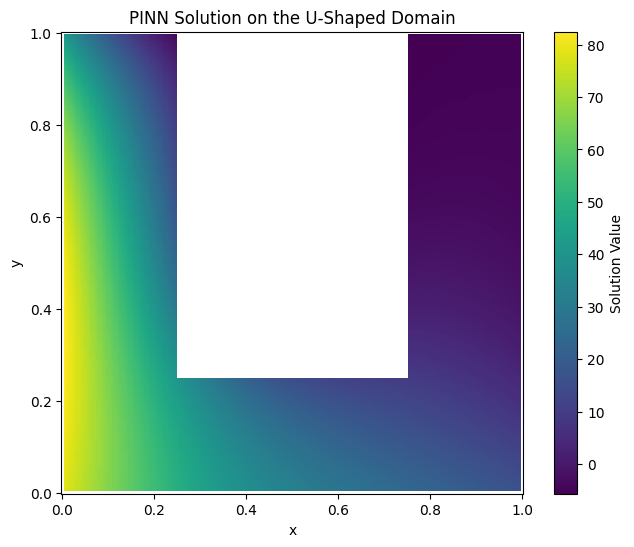

In [11]:
# Visualize the solution
with torch.no_grad():
    # Create a grid for visualization
    x = np.linspace(0, 1, 200)
    y = np.linspace(0, 1, 200)
    xx, yy = np.meshgrid(x, y)
    grid_points = np.column_stack([xx.ravel(), yy.ravel()])
    grid_points_torch = torch.tensor(grid_points, dtype=torch.float32)
    u_pred = model(grid_points_torch).cpu().numpy().reshape(xx.shape)

# Mask out points outside the U-shape
polygon = Polygon(u_shape_polyline)
mask = np.array([polygon.contains(Point(p)) for p in grid_points])
u_pred_masked = np.where(mask.reshape(xx.shape), u_pred, np.nan)

# Plot the solution as a 2D heatmap
plt.figure(figsize=(8, 6))
plt.pcolormesh(xx, yy, u_pred_masked, cmap="viridis", shading="auto")
plt.colorbar(label="Solution Value")
plt.title("PINN Solution on the U-Shaped Domain")
plt.xlabel("x")
plt.ylabel("y")
plt.gca().set_aspect('equal')
plt.show()

Epoch 0, Loss: 0.06094902753829956
Epoch 500, Loss: 5.186555540603877e-07
Epoch 1000, Loss: 1.2305385155286785e-07
Epoch 1500, Loss: 9.001397671681843e-08
Epoch 2000, Loss: 7.252081246633679e-08
Epoch 2500, Loss: 5.537965819257806e-08
Epoch 3000, Loss: 3.983473106927704e-08
Epoch 3500, Loss: 2.6888457682616718e-08
Epoch 4000, Loss: 1.704572483163247e-08
Epoch 4500, Loss: 1.0820034646030763e-08


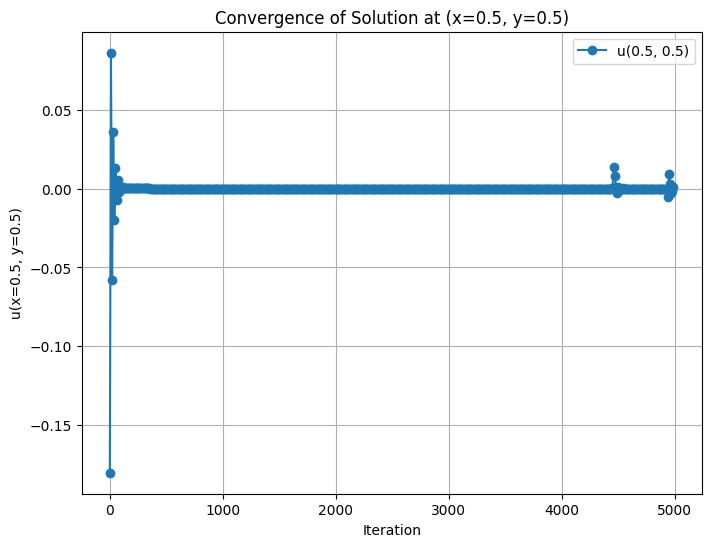

In [15]:
# Fixed spatial point for monitoring
fixed_point = torch.tensor([[0.5, 0.5]], dtype=torch.float32)

# Array to store predicted values at each iteration
convergence_values = []

# Training loop with monitoring
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 5000

for epoch in range(epochs):
    optimizer.zero_grad()
    loss_pde = pde_loss(model, collocation_points)
    loss_bc = boundary_loss(model, boundary_points, boundary_values)
    loss = loss_pde + loss_bc
    loss.backward()
    optimizer.step()

    # Store the prediction at the fixed point
    if epoch % 10 == 0:  # Record every 10 epochs to reduce noise
        u_fixed = model(fixed_point).detach().cpu().item()
        convergence_values.append(u_fixed)

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Plot the convergence
iterations = np.arange(0, len(convergence_values)) * 10  # Iterations corresponding to recorded values
plt.figure(figsize=(8, 6))
plt.plot(iterations, convergence_values, label=f"u(0.5, 0.5)", marker="o")
plt.title("Convergence of Solution at (x=0.5, y=0.5)")
plt.xlabel("Iteration")
plt.ylabel("u(x=0.5, y=0.5)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
torch.save(model.state_dict(), "PINN.pt")

In [ ]:
model.load_state_dict(torch.load('PINN.pt'), strict=False)